Installing necessary prereqs: [NetworkX](https://networkx.org/documentation/stable/reference/index.html) for graphing, [PuLP](https://coin-or.github.io/pulp/main/index.html) for linear programming.

In [1]:
%pip install networkx pulp

Note: you may need to restart the kernel to use updated packages.


In [2]:

import json
import networkx as nx

fileName = "map_ct_nw_weights"

file = open("map_data/" + fileName + ".json")
data = json.load(file)

# adjacencies = data["adj"]
# # TODO: Shits the bed if there's anything other than letters and _
# countyNames = data["GEOID"]
# pop = data["pop"]

adjacencies = []
countyNames = []
pop = []
weights = []
for countyInfo in data:
    countyNames.append(countyInfo["GEOID"])
    adjacencies.append(countyInfo["adj"])
    pop.append(countyInfo["pop"])
    weights.append(countyInfo["weights"])


# Number of districts
NUM_DISTRICTS = 5

# Population Tolerance
ALPHA = .05

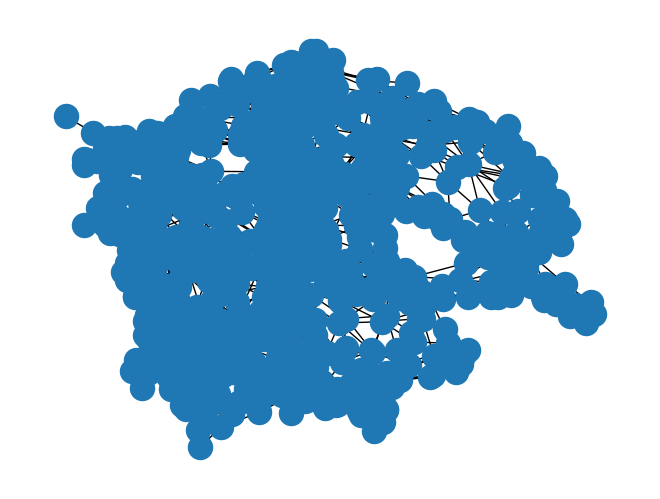

In [4]:
from random import Random

stateGraph = nx.Graph()

r =  Random(51535162)
totalPop = 0
# Add the nodes as necessary

for i in range(len(adjacencies)):
    # Adds node for each set of adjacencies
    totalPop += pop[i]
    # Adds necessary edges; double-adding doesn't matter
    # try:
    for j in range(len(adjacencies[i])):
        # print(i,j)
        stateGraph.add_edge(countyNames[i], countyNames[adjacencies[i][j]], weight=float(weights[i][j]))
    # except:
    #         print(i)
    #         stateGraph.add_edge(countyNames[i], countyNames[adjacencies[i]], weight=weights[i])

# Population per district
targetPop = totalPop / NUM_DISTRICTS

nx.draw(stateGraph)

In [5]:
%%capture cap

import pulp

def CutPartition(remainingGraph):
    prog = pulp.LpProblem("CutPartition", pulp.LpMinimize)

    # Defining Partition Binary
    xVars = []
    xVarMap = {}
    for n in remainingGraph.nodes:
        var = pulp.LpVariable("x" + str(n), cat=pulp.LpInteger)
        xVarMap[n] = var
        xVars.append(var)
        prog += var
    # Defining crossing binary
    edgeVars = []
    weights = []
    for n, m in remainingGraph.edges:
        # edgeVal = pulp.LpAffineExpression([(xVarMap[n], 1), (xVarMap[m], -1)])
        absEdgeVal = pulp.LpVariable('y' + str(n) + str(m), cat=pulp.LpBinary)

        # Ensures that y is either 1 or 0. 1 if n!=m (crossing), otherwise 0.
        prog += absEdgeVal == 1 - (xVarMap[n] == xVarMap[m])

        edgeVars.append(absEdgeVal)
        weights.append(remainingGraph[n][m]['weight'])

    # Defining Partition Classification
    zVars = []
    zVarMap = {}
    for n in remainingGraph.nodes:
      zVarMap[n] = {}
      for d in range(NUM_DISTRICTS):
        var = pulp.LpVariable("z" + str(n) + str(d), cat=pulp.LpBinary)
        zVarMap[n][d] = var
        zVars.append(var)
        prog += var

    # Indices and Partition Relationship
    for n in remainingGraph.nodes:
      for d in range(NUM_DISTRICTS):
        prog += zVarMap[n][d] == (xVarMap[n] == d)

    # Partition Exclusivity
    for n in remainingGraph.nodes:
      distVariables = []
      for d in range(NUM_DISTRICTS):
        distVariables.append(zVarMap[n][d])
      prog += pulp.lpSum(zVarMap[n]) == 1 #for each nodes' district variables, they need to add to max 1

    # Each Partition Subset sum
    for d in range(NUM_DISTRICTS):
      popVariables = []
      idx = 0
      for i in remainingGraph.nodes:
          popVariables.append(pulp.LpAffineExpression(zVarMap[i][d] * pop[idx]))
          idx += 1
      # Max Pop
      prog += pulp.lpSum(popVariables) <= targetPop * (1 + ALPHA)
      # Min Pop
      prog += pulp.lpSum(popVariables) >= targetPop * (1 - ALPHA)

    # Each Partition Connected
    for d in range(NUM_DISTRICTS):
      for i in remainingGraph.nodes:
          sumParts = []
          jidx = 0
          for j in remainingGraph.nodes:
              if i == jidx: break
              if remainingGraph.has_edge(i, jidx):
                  sumParts.append(remainingGraph[i][jidx]['weight'] * zVarMap[j][d])
              jidx += 1
          totalLH = pulp.LpAffineExpression(zVarMap[j][d] * pulp.lpSum(sumParts))
          prog += pulp.LpConstraint(totalLH, pulp.LpConstraintGE, 0)

    # Define Minimization Target
    # Edgeweights
    edgeWeightVars = []
    for i in range(len(edgeVars)):
        edgeWeightVars.append(pulp.LpAffineExpression(edgeVars[i] * weights[i]))
    prog += pulp.LpAffineExpression(pulp.lpSum(edgeWeightVars), name="Z")

    print("Sending to solver...")
    print(prog)
    Solver_name = 'PULP_CBC_CMD'
    solver = pulp.getSolver(Solver_name, threads=12)
    soln = prog.solve(solver)

    print(soln)

    toReturn = {}

    districtPop = 0
    print(xVars)
    for i in range(len(xVars)):
        if(xVars[i].value() == 1):
            districtPop += pop[i]
            toReturn[xVars[i].name] = xVars[i].value()
            print(xVars[i].name, xVars[i].value())
    if(districtPop >= targetPop * (1 + ALPHA) or districtPop <= targetPop * (1-ALPHA)):
        raise ValueError("District Generated not of Proper Population")
    return toReturn


remainingGraph = stateGraph.copy()
districts = []
while len(districts) < NUM_DISTRICTS - 1:
    cutResult = CutPartition(remainingGraph)
    newDistrict = []
    for d in cutResult.keys():
        # Gets rid of the x
        # print(d)
        newDistrict.append(d[1:])
    # Appends the new district to our list of districts
    districts.append(newDistrict)
    oldSize = remainingGraph.order()
    # Removes those nodes from the district
    remainingGraph.remove_nodes_from(newDistrict)
    newSize = remainingGraph.order()
    # Verify that all of the nodes were removed
    if(newSize != oldSize - len(newDistrict)):
        print(remainingGraph.nodes)
        print(newDistrict)
        raise(ValueError("Districts were not removed appropriately"))
    # print(newDistrict)
newDistrict = []
for d in remainingGraph.nodes:
    # Gets rid of the x
    newDistrict.append(d)
districts.append(newDistrict)

#Confirm total size is appropriate
totalCountiesinDistricts = 0
for d in districts:
    totalCountiesinDistricts += len(d)
if(totalCountiesinDistricts != len(countyNames)):
    raise(ValueError("Number of districts in plan does not match number of districts."))

# Save the captured output to a text file
with open('txt_outputs/' + fileName + '.txt', 'w') as file:
    file.write(cap.stdout)

ValueError: District Generated not of Proper Population

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/z3/3qb7cv41693fmz3b6hbntjkr0000gn/T/87519a42a7ea4c9191ab92ca922f8f79-pulp.mps -threads 12 -timeMode elapsed -branch -printingOptions all -solution /var/folders/z3/3qb7cv41693fmz3b6hbntjkr0000gn/T/87519a42a7ea4c9191ab92ca922f8f79-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 10578 COLUMNS
At line 51723 RHS
At line 62297 BOUNDS
At line 69031 ENDATA
Problem MODEL has 10573 rows, 6733 columns and 25541 elements
Coin0008I MODEL read with 0 errors
threads was changed from 0 to 12
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.25 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.28   (Wallclock seconds):       0.29



In [ ]:
import csv

file = open("district_outputs" + fileName + '.csv', 'w')
w = csv.writer(file)
w.writerow(["district", "precinct"])
for i in range(len(districts)):
    for j in range(len(districts[i])):
        w.writerow([i + 1, districts[i][j]])
file.close()